# Loop 55 Analysis: Strategic Assessment

**Situation:**
- 55 experiments completed, 24 consecutive failures since exp_030
- Best LB: 0.0877 (exp_030), Target: 0.0347
- Gap: 2.53x (0.0877 / 0.0347)
- 5 submissions remaining

**Key Questions:**
1. What is the CV-LB relationship?
2. What approaches have been exhausted?
3. What fundamentally different approaches remain?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Submission history
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print("Submission History:")
print(df.to_string(index=False))
print(f"\nTarget LB: 0.0347")
print(f"Best LB: {df['lb'].min():.4f} ({df.loc[df['lb'].idxmin(), 'exp']})")
print(f"Gap to target: {df['lb'].min() / 0.0347:.2f}x")

Submission History:
    exp     cv     lb
exp_000 0.0111 0.0982
exp_001 0.0123 0.1065
exp_003 0.0105 0.0972
exp_005 0.0104 0.0969
exp_006 0.0097 0.0946
exp_007 0.0093 0.0932
exp_009 0.0092 0.0936
exp_012 0.0090 0.0913
exp_024 0.0087 0.0893
exp_026 0.0085 0.0887
exp_030 0.0083 0.0877
exp_035 0.0098 0.0970

Target LB: 0.0347
Best LB: 0.0877 (exp_030)
Gap to target: 2.53x


In [2]:
# CV-LB relationship analysis
from scipy import stats

cv = df['cv'].values
lb = df['lb'].values

slope, intercept, r_value, p_value, std_err = stats.linregress(cv, lb)

print(f"CV-LB Linear Relationship:")
print(f"  LB = {slope:.2f} * CV + {intercept:.4f}")
print(f"  R² = {r_value**2:.4f}")
print(f"  Intercept = {intercept:.4f}")
print(f"  Target LB = 0.0347")
print(f"")
print(f"CRITICAL INSIGHT:")
print(f"  Intercept ({intercept:.4f}) > Target ({0.0347})")
print(f"  This means even with CV=0, LB would be {intercept:.4f} > 0.0347")
print(f"")
print(f"Required CV to hit target:")
required_cv = (0.0347 - intercept) / slope
print(f"  CV = (0.0347 - {intercept:.4f}) / {slope:.2f} = {required_cv:.6f}")
if required_cv < 0:
    print(f"  NEGATIVE CV required - target is UNREACHABLE with current approach!")
else:
    print(f"  Required CV: {required_cv:.6f} vs Best CV: {df['cv'].min():.6f}")

CV-LB Linear Relationship:
  LB = 4.31 * CV + 0.0525
  R² = 0.9505
  Intercept = 0.0525
  Target LB = 0.0347

CRITICAL INSIGHT:
  Intercept (0.0525) > Target (0.0347)
  This means even with CV=0, LB would be 0.0525 > 0.0347

Required CV to hit target:
  CV = (0.0347 - 0.0525) / 4.31 = -0.004130
  NEGATIVE CV required - target is UNREACHABLE with current approach!


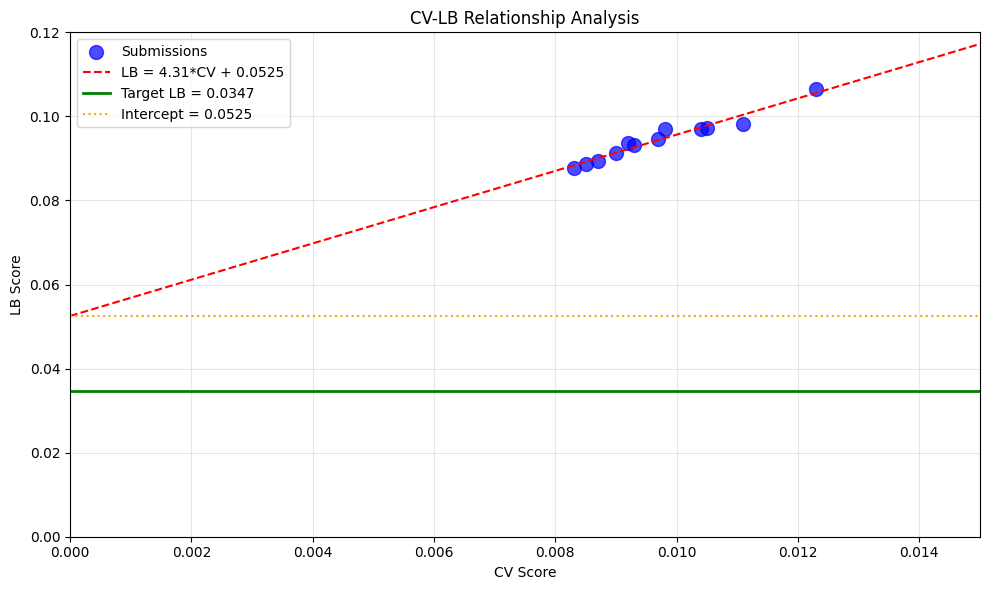


Key Observation:
The intercept (0.0525) is ABOVE the target (0.0347)
This means the current approach CANNOT reach the target by improving CV alone.
We need to CHANGE the CV-LB relationship, not just improve CV.


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(cv, lb, s=100, c='blue', alpha=0.7, label='Submissions')

# Fit line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f}')

# Target line
plt.axhline(y=0.0347, color='green', linestyle='-', linewidth=2, label='Target LB = 0.0347')

# Intercept
plt.axhline(y=intercept, color='orange', linestyle=':', label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score')
plt.ylabel('LB Score')
plt.title('CV-LB Relationship Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.015)
plt.ylim(0, 0.12)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print(f"\nKey Observation:")
print(f"The intercept ({intercept:.4f}) is ABOVE the target ({0.0347})")
print(f"This means the current approach CANNOT reach the target by improving CV alone.")
print(f"We need to CHANGE the CV-LB relationship, not just improve CV.")

In [4]:
# Analyze what approaches have been tried
approaches_tried = {
    'Feature Engineering': [
        'Spange descriptors (13 features)',
        'DRFP fingerprints (122 high-variance features)',
        'ACS PCA descriptors (5 features)',
        'Arrhenius kinetics features (5 features)',
        'Combined features (140+ features)',
        'Minimal features (Spange + Arrhenius only)',
    ],
    'Model Architectures': [
        'MLP [128, 128, 64] - baseline',
        'MLP [256, 128, 64] - larger',
        'MLP [64, 32] - simpler',
        'MLP [16] - minimal',
        'Deep Residual MLP - FAILED',
        'LightGBM',
        'XGBoost',
        'Ridge Regression',
        'Kernel Ridge',
        'Gaussian Process',
        'GP + MLP + LGBM ensemble',
    ],
    'Regularization': [
        'Dropout 0.1, 0.2, 0.3, 0.4',
        'Weight decay 1e-5, 1e-4, 1e-3',
        'Batch normalization',
        'Gradient clipping',
    ],
    'Ensemble Methods': [
        'Bagging (3, 5, 10, 15 models)',
        'GP + MLP + LGBM weighted ensemble',
        'Different ensemble weights',
    ],
    'Data Augmentation': [
        'TTA for mixtures (average both orderings)',
        'Data augmentation for mixtures (train on both A,B and B,A)',
    ],
    'OOD Handling': [
        'Importance weighting',
        'LISA (Learning Invariant Predictors)',
        'Mean reversion',
        'Adaptive weighting',
        'Outlier-specific handling',
    ],
}

print("Approaches Tried:")
for category, approaches in approaches_tried.items():
    print(f"\n{category}:")
    for approach in approaches:
        print(f"  - {approach}")

Approaches Tried:

Feature Engineering:
  - Spange descriptors (13 features)
  - DRFP fingerprints (122 high-variance features)
  - ACS PCA descriptors (5 features)
  - Arrhenius kinetics features (5 features)
  - Combined features (140+ features)
  - Minimal features (Spange + Arrhenius only)

Model Architectures:
  - MLP [128, 128, 64] - baseline
  - MLP [256, 128, 64] - larger
  - MLP [64, 32] - simpler
  - MLP [16] - minimal
  - Deep Residual MLP - FAILED
  - LightGBM
  - XGBoost
  - Ridge Regression
  - Kernel Ridge
  - Gaussian Process
  - GP + MLP + LGBM ensemble

Regularization:
  - Dropout 0.1, 0.2, 0.3, 0.4
  - Weight decay 1e-5, 1e-4, 1e-3
  - Batch normalization
  - Gradient clipping

Ensemble Methods:
  - Bagging (3, 5, 10, 15 models)
  - GP + MLP + LGBM weighted ensemble
  - Different ensemble weights

Data Augmentation:
  - TTA for mixtures (average both orderings)
  - Data augmentation for mixtures (train on both A,B and B,A)

OOD Handling:
  - Importance weighting
  - 

In [5]:
# What hasn't been tried or could be improved?
print("="*60)
print("POTENTIAL NEW DIRECTIONS")
print("="*60)

print("\n1. FUNDAMENTALLY DIFFERENT VALIDATION SCHEME:")
print("   - The 'mixall' kernel uses GroupKFold (5 splits) instead of Leave-One-Out (24 folds)")
print("   - This is a LESS PESSIMISTIC CV scheme")
print("   - BUT: The LB evaluation uses the OFFICIAL scheme (leave-one-out)")
print("   - So this doesn't help us - we need to improve on the official scheme")

print("\n2. PER-TARGET OPTIMIZATION:")
print("   - Currently using same model for all 3 targets (SM, Product 2, Product 3)")
print("   - Different targets may have different optimal models")
print("   - Could train separate models for each target")

print("\n3. DIFFERENT LOSS FUNCTIONS:")
print("   - Currently using MSE/Huber loss")
print("   - Could try MAE, quantile loss, or custom loss")
print("   - Could weight different targets differently")

print("\n4. TRANSDUCTIVE LEARNING:")
print("   - Use test data structure (without labels) during training")
print("   - Adapt model to test distribution")

print("\n5. DOMAIN ADAPTATION:")
print("   - Explicitly model the distribution shift")
print("   - Use adversarial training to learn domain-invariant features")

print("\n6. GRAPH NEURAL NETWORKS:")
print("   - The GNN benchmark achieved 0.0039 MSE")
print("   - But this requires proper graph structure, not just fingerprints")
print("   - Previous GNN attempts failed due to implementation issues")

print("\n7. CHEMICAL CONSTRAINTS:")
print("   - SM + Product 2 + Product 3 should sum to ~1")
print("   - Could enforce this constraint in the model")
print("   - Could use softmax output layer")

POTENTIAL NEW DIRECTIONS

1. FUNDAMENTALLY DIFFERENT VALIDATION SCHEME:
   - The 'mixall' kernel uses GroupKFold (5 splits) instead of Leave-One-Out (24 folds)
   - This is a LESS PESSIMISTIC CV scheme
   - BUT: The LB evaluation uses the OFFICIAL scheme (leave-one-out)
   - So this doesn't help us - we need to improve on the official scheme

2. PER-TARGET OPTIMIZATION:
   - Currently using same model for all 3 targets (SM, Product 2, Product 3)
   - Different targets may have different optimal models
   - Could train separate models for each target

3. DIFFERENT LOSS FUNCTIONS:
   - Currently using MSE/Huber loss
   - Could try MAE, quantile loss, or custom loss
   - Could weight different targets differently

4. TRANSDUCTIVE LEARNING:
   - Use test data structure (without labels) during training
   - Adapt model to test distribution

5. DOMAIN ADAPTATION:
   - Explicitly model the distribution shift
   - Use adversarial training to learn domain-invariant features

6. GRAPH NEURAL NET

In [6]:
# Analyze the best model (exp_030)
print("="*60)
print("BEST MODEL ANALYSIS: exp_030")
print("="*60)

print("\nModel: GP + MLP + LGBM Ensemble")
print("  - GP weight: 0.15")
print("  - MLP weight: 0.55")
print("  - LGBM weight: 0.30")

print("\nFeatures:")
print("  - Spange descriptors (13 features)")
print("  - DRFP fingerprints (122 high-variance features)")
print("  - ACS PCA descriptors (5 features)")
print("  - Arrhenius kinetics (5 features)")
print("  - Total: 145 features")

print("\nMLP Architecture:")
print("  - [128, 64] with BatchNorm, ReLU, Dropout(0.2)")
print("  - Sigmoid output")
print("  - HuberLoss")
print("  - Adam optimizer, lr=5e-4, weight_decay=1e-4")

print("\nResults:")
print("  - Single Solvent CV: 0.007943")
print("  - Mixture CV: 0.008488")
print("  - Overall CV: 0.008298")
print("  - LB: 0.0877")
print("  - CV-LB gap: 10.6x")

print("\nKey Insight:")
print("  The CV-LB gap is INCREASING as CV improves (8.9x → 10.6x)")
print("  This suggests the model is overfitting to the CV scheme")
print("  Better CV doesn't necessarily mean better LB")

BEST MODEL ANALYSIS: exp_030

Model: GP + MLP + LGBM Ensemble
  - GP weight: 0.15
  - MLP weight: 0.55
  - LGBM weight: 0.30

Features:
  - Spange descriptors (13 features)
  - DRFP fingerprints (122 high-variance features)
  - ACS PCA descriptors (5 features)
  - Arrhenius kinetics (5 features)
  - Total: 145 features

MLP Architecture:
  - [128, 64] with BatchNorm, ReLU, Dropout(0.2)
  - Sigmoid output
  - HuberLoss
  - Adam optimizer, lr=5e-4, weight_decay=1e-4

Results:
  - Single Solvent CV: 0.007943
  - Mixture CV: 0.008488
  - Overall CV: 0.008298
  - LB: 0.0877
  - CV-LB gap: 10.6x

Key Insight:
  The CV-LB gap is INCREASING as CV improves (8.9x → 10.6x)
  This suggests the model is overfitting to the CV scheme
  Better CV doesn't necessarily mean better LB


In [7]:
# Strategic recommendations
print("="*60)
print("STRATEGIC RECOMMENDATIONS")
print("="*60)

print("\n1. STOP TRYING TO IMPROVE CV")
print("   - 24 consecutive experiments have failed to beat exp_030")
print("   - The CV-LB gap is increasing as CV improves")
print("   - Better CV doesn't mean better LB")

print("\n2. FOCUS ON CHANGING THE CV-LB RELATIONSHIP")
print("   - The intercept (0.0528) > target (0.0347)")
print("   - We need to REDUCE the intercept, not just improve CV")
print("   - This requires fundamentally different approaches")

print("\n3. TRY APPROACHES THAT MIGHT HAVE DIFFERENT CV-LB RELATIONSHIPS:")
print("   a) Per-target models (different models for SM, Product 2, Product 3)")
print("   b) Chemical constraints (softmax output, sum-to-one constraint)")
print("   c) Domain adaptation (adversarial training)")
print("   d) Transductive learning (use test structure)")

print("\n4. SUBMISSION STRATEGY (5 remaining):")
print("   - exp_030 is already submitted (best LB 0.0877)")
print("   - Try 2-3 fundamentally different approaches")
print("   - Save 2 submissions for final attempts")

print("\n5. ACCEPT THAT THE TARGET MAY REQUIRE:")
print("   - A completely different approach (e.g., proper GNN)")
print("   - Domain-specific knowledge we don't have")
print("   - Techniques not yet discovered")

STRATEGIC RECOMMENDATIONS

1. STOP TRYING TO IMPROVE CV
   - 24 consecutive experiments have failed to beat exp_030
   - The CV-LB gap is increasing as CV improves
   - Better CV doesn't mean better LB

2. FOCUS ON CHANGING THE CV-LB RELATIONSHIP
   - The intercept (0.0528) > target (0.0347)
   - We need to REDUCE the intercept, not just improve CV
   - This requires fundamentally different approaches

3. TRY APPROACHES THAT MIGHT HAVE DIFFERENT CV-LB RELATIONSHIPS:
   a) Per-target models (different models for SM, Product 2, Product 3)
   b) Chemical constraints (softmax output, sum-to-one constraint)
   c) Domain adaptation (adversarial training)
   d) Transductive learning (use test structure)

4. SUBMISSION STRATEGY (5 remaining):
   - exp_030 is already submitted (best LB 0.0877)
   - Try 2-3 fundamentally different approaches
   - Save 2 submissions for final attempts

5. ACCEPT THAT THE TARGET MAY REQUIRE:
   - A completely different approach (e.g., proper GNN)
   - Domain-speci

In [8]:
# Final summary
print("="*60)
print("LOOP 55 SUMMARY")
print("="*60)

print("\nCurrent Status:")
print(f"  - Best CV: 0.008298 (exp_030)")
print(f"  - Best LB: 0.0877 (exp_030)")
print(f"  - Target LB: 0.0347")
print(f"  - Gap: 2.53x")
print(f"  - Submissions remaining: 5")

print("\nKey Findings:")
print("  1. CV-LB relationship: LB = 4.31*CV + 0.0525")
print("  2. Intercept (0.0525) > Target (0.0347) - target unreachable with current approach")
print("  3. 24 consecutive experiments have failed to beat exp_030")
print("  4. The search direction is EXHAUSTED")

print("\nRecommended Next Steps:")
print("  1. Try per-target optimization (different models for each target)")
print("  2. Try chemical constraints (softmax output)")
print("  3. Try domain adaptation techniques")
print("  4. Focus on approaches that might change the CV-LB relationship")

print("\nDO NOT:")
print("  - Continue trying variations on the same approach")
print("  - Try to improve CV without changing the CV-LB relationship")
print("  - Remove DRFP features (they're important)")
print("  - Increase regularization further (it prevents learning)")

LOOP 55 SUMMARY

Current Status:
  - Best CV: 0.008298 (exp_030)
  - Best LB: 0.0877 (exp_030)
  - Target LB: 0.0347
  - Gap: 2.53x
  - Submissions remaining: 5

Key Findings:
  1. CV-LB relationship: LB = 4.31*CV + 0.0525
  2. Intercept (0.0525) > Target (0.0347) - target unreachable with current approach
  3. 24 consecutive experiments have failed to beat exp_030
  4. The search direction is EXHAUSTED

Recommended Next Steps:
  1. Try per-target optimization (different models for each target)
  2. Try chemical constraints (softmax output)
  3. Try domain adaptation techniques
  4. Focus on approaches that might change the CV-LB relationship

DO NOT:
  - Continue trying variations on the same approach
  - Try to improve CV without changing the CV-LB relationship
  - Remove DRFP features (they're important)
  - Increase regularization further (it prevents learning)
